In [13]:
import ROOT
f = ROOT.TFile.Open("/mnt/data/eos/run307/run307.root")
events = f.Get("events")
events.Print()

******************************************************************************
*Tree    :events    : events                                                 *
*Entries :     8436 : Total =       126980201 bytes  File  Size =   37367136 *
*        :          : Tree compression factor =   3.40                       *
******************************************************************************
*Br    0 :event_number : event_number/I                                      *
*Entries :     8436 : Total  Size=      34419 bytes  File Size  =      12007 *
*Baskets :        2 : Basket Size=      51200 bytes  Compression=   2.82     *
*............................................................................*
*Br    1 :nhit      : nhit/I                                                 *
*Entries :     8436 : Total  Size=      34371 bytes  File Size  =      12831 *
*Baskets :        2 : Basket Size=      51200 bytes  Compression=   2.64     *
*...................................................

(8436,)


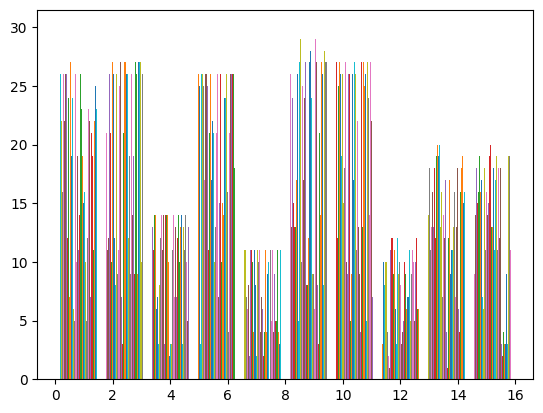

In [14]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
df = ROOT.RDataFrame("events","/mnt/data/eos/run307/run307.root")
nhits = df.AsNumpy(columns=["nhit"])["nhit"]
event_number = df.AsNumpy(columns=["event_number"])["event_number"]
board = df.AsNumpy(columns=["board"])["board"]
channel = df.AsNumpy(columns=["channel"])["channel"]
print(nhits.shape)
plt.hist(nhits,bins=np.arange(-0.5,255.5,10))
plt.show()




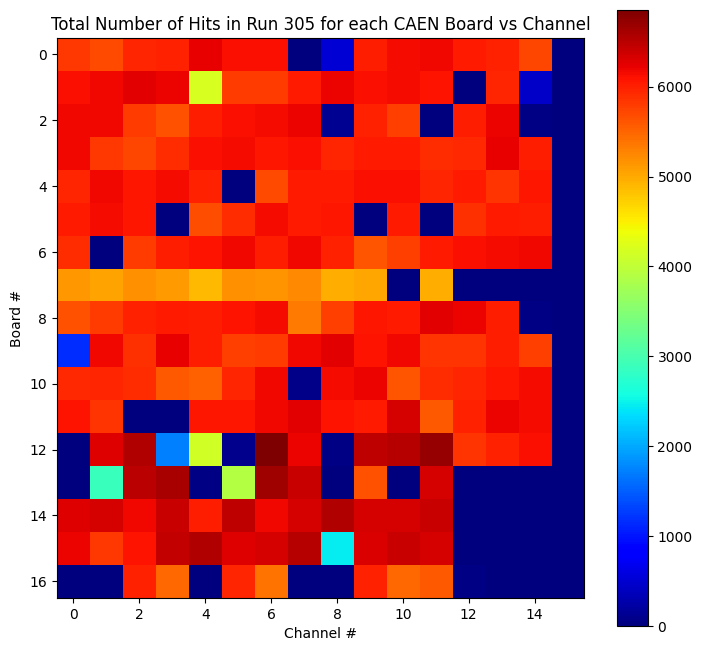

In [88]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
rdf = ROOT.RDataFrame("events","/mnt/data/eos/run307/run307.root")
nhit = rdf.AsNumpy(columns=["nhit"])["nhit"]
event_number = rdf.AsNumpy(columns=["event_number"])["event_number"]
board = rdf.AsNumpy(columns=["board"])["board"]
channel = rdf.AsNumpy(columns=["channel"])["channel"]

PMTHits = np.zeros([17,16])
#print(PMTHits.shape)
for iEvt in range(0,len(event_number)):
    #print(len(board[aEvt]),len(channel[aEvt]), nhit[aEvt])
    for iHit in range(0,len(board[iEvt])):
        #print(board[iEvt][iHit])
        PMTHits[board[iEvt][iHit]][channel[iEvt][iHit]]=PMTHits[board[iEvt][iHit]][channel[iEvt][iHit]]+1

plt.figure(figsize=(17/2,16/2))
plt.imshow(PMTHits, cmap='jet')
plt.title("Total Number of Hits in Run 305 for each CAEN Board vs Channel")
plt.xlabel("Channel #")
plt.ylabel("Board #")
plt.colorbar()
plt.show()

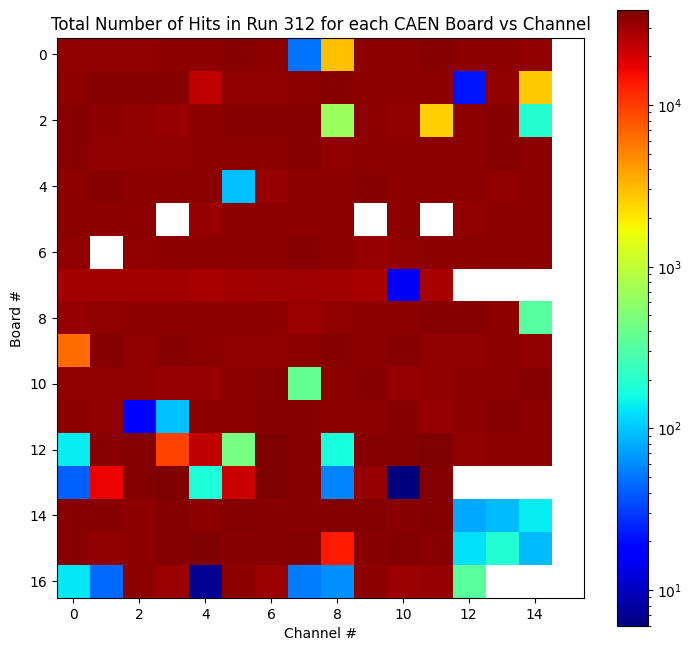

nMuonHits,nTotalHits,nMuonHits/nTotalHits
711.0 7109369.0 0.00010000887561188623


In [115]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
rdf = ROOT.RDataFrame("events","/mnt/data/eos/run312/run312.root")
nhit = rdf.AsNumpy(columns=["nhit"])["nhit"]
event_number = rdf.AsNumpy(columns=["event_number"])["event_number"]
board = rdf.AsNumpy(columns=["board"])["board"]
channel = rdf.AsNumpy(columns=["channel"])["channel"]
charge = rdf.AsNumpy(columns=["charge"])["charge"]

#print(len(charge[0]))
#print(nhit[0])

PMTHits = np.zeros([17,16])
#print(PMTHits.shape)
for iEvt in range(0,len(event_number)):
    #print(len(board[aEvt]),len(channel[aEvt]), nhit[aEvt])
    for iHit in range(0,len(board[iEvt])):
        #print(board[iEvt][iHit])
        PMTHits[board[iEvt][iHit],channel[iEvt][iHit]]=PMTHits[board[iEvt][iHit],channel[iEvt][iHit]]+1

plt.figure(figsize=(17/2,16/2))
plt.imshow(PMTHits, cmap='jet',norm=colors.LogNorm())
plt.title("Total Number of Hits in Run 312 for each CAEN Board vs Channel")
plt.xlabel("Channel #")
plt.ylabel("Board #")
plt.colorbar()
plt.show()

nMuonHits = np.sum(PMTHits[14:16,12:15])
nTotalHits= np.sum(PMTHits)
print("nMuonHits,nTotalHits,nMuonHits/nTotalHits")
print(nMuonHits,nTotalHits,nMuonHits/nTotalHits)




In [ ]:
df = pd.DataFrame({
    'nhit': nhit,
    'event_number': event_number,
    'board': board,
    'channel': channel
})
df1 = df[df["event_number"] ==1]

#print(len(nhit))
#print(board[0], board[1])

Error in <TInterpreter::TCling::AutoLoad>: failure loading library libRATDict.so for vector<vector<int> >


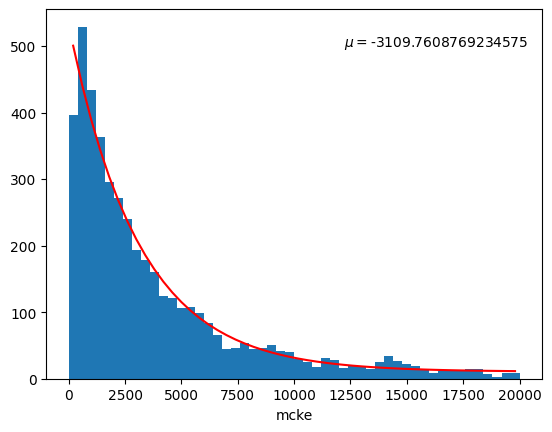

4868


In [3]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
df = ROOT.RDataFrame("output","test.root")
mcke = df.AsNumpy(columns=["mcke"])["mcke"]
mcpdg = df.AsNumpy(columns=["mcpdg"])["mcpdg"]
plt.hist(mcke, bins=np.arange(-0.5,20000,400))
ax =plt.gca()
histy,histx = np.histogram(mcke, bins=np.arange(-0.5,20000,400))
plt.xlabel("mcke")
bin_centers =[]
for ie in range(1,len(histx)):
    bin_centers.append((histx[ie]+histx[ie-1])/2)
bin_centers = np.array(bin_centers)
#print(bin_centers)

from scipy.optimize import curve_fit
def expfit(x,a,b,mean):
    return a+b*np.exp(mean*x)

param0 = (0,100,-0.0001)
paramfit, paramErr = curve_fit(expfit,bin_centers,histy,param0)
#print(paramfit[2])
#print(3*paramfit[2])
fitfun = expfit(bin_centers,paramfit[0],paramfit[1],paramfit[2])
plt.plot(bin_centers, fitfun, "r-")
plt.text(0.6,0.9,"$\mu=$"+ str(1/paramfit[2]), transform=ax.transAxes)
plt.show()

print(len(mcke))
